# Sovereign Catastrophe Bond Design 

In this notebook we will first design a single-country cat bond for the carribean state Grenada. We will have a look at the risk assessment, the structure of the bond, the calibration of the payout function and finally the simulation of the bond itself. We will price the bond to evaluate how expensive such a insurance would be for the country. Having had a detailed look at the creation of the bond, we will use a wrapper function to create two more single-country bonds for different countries. These countries are St. Kitts and Nevis, also located in the Carribean, south of Grenada, and Comoros located next to Madagascar in the Southern Indian basin. We will assess the relevant metrics for the bonds and then consturct mutli-country bonds using a pair of the three chosen countries. We will compare their pricing, as well as their usefullness for the countries. 

If there is time left, feel free to play around with the functions. You can modify the bond settings, what it should protect, how much capital you have, etc.. You can also create bonds multi-country bonds using different risk pools to see how it would impact the pricing.

In [106]:
#import general packages
import numpy as np
from scipy.stats import spearmanr
from colorama import Fore, Style, Back

%load_ext autoreload
%autoreload 2
import exposures as ex
import impact as cimp
import bound_prot_dam as bpd
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import functions as fct
import calc_premium as cp
import simulate_bond as sb
import alt_pay_opt as apo
import climada_days_functions as cdf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Designe Single-Country Cat Bond - Grenada

### Define Bond Characteristics

In [107]:
#choose country using 3-digits numeric country code
country = 882 #Grenada

#define minimum return period to be covered
lower_rp = 25

#define maximum return period to be covered
upper_rp = 50

#define benchmark sharpe ratio
target_sharpe = 0.5

#define the risk free rate
rf_rate = 0.0

We have to define some important variables before starting to create the bond. 
First, we have to choose the country for which the bond is intended and second, we have to define what minimum return period of damage our bond should protect. The lower the return period the higher the annual expected loss and therefore also the price. Similaray, we have to define the maximum damage the bond can cover. This can also done by specifying a return period, which is 50 years in our case. Remember that cat bonds are designed to insure low frequency, high seveirity events.

Additionally, we also have to set the benchmark for the sharpe ratio. This is set to 0.5 as it corresponds to the historical performance of high yield corporate bonds, which have a similar risk level to catastrophe bonds. 

We also have to set the risk free rate as it is needed to calculate the sharpe ratio and the total returns. In this example we will assume it remains constant throughout the simulated years and set it to 5% which corresponds roughly to the rates currently offered for short therm US treasury bonds, which are generally assumed to be "without risk".

### Assess Natural Hazard Risk


#### Generate Exposure Data and TC Hazards 
1. Import TC tracks from the relevant basin <br>
2. Generate exposure data using GDP as total exposure, 2020 as reference year, and 30 arcsec as resolution. <br>
3. Generate centroids at the locations of the exposed assets <br>
4. Filter TC tracks so that the updated dataset only includes tracks which can trigger a payout <br>
5. Generate TC hazards


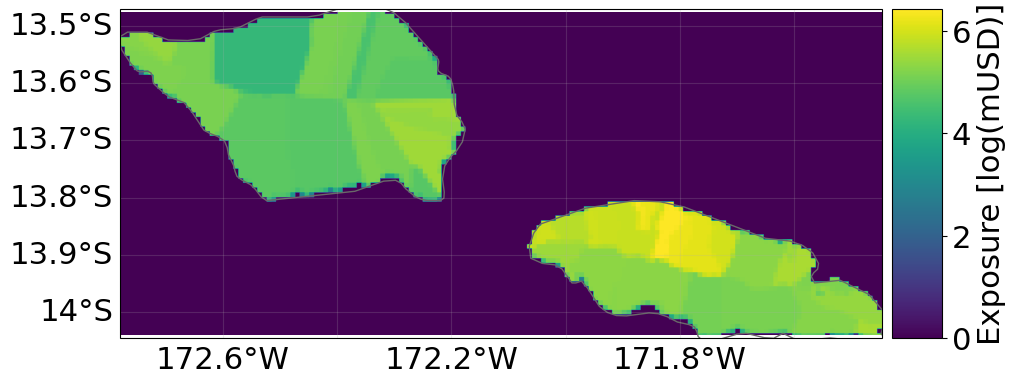

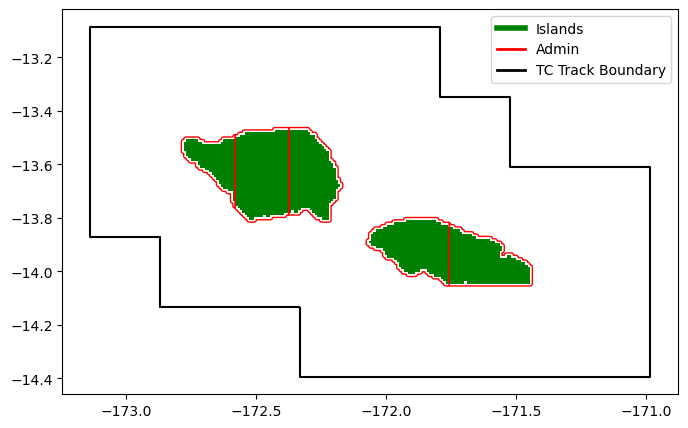

Number of tracks in SP basin: 1767


In [108]:
exp, applicable_basins, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex.init_TC_exp(country, 
                                                                                         grid_size=600, 
                                                                                         buffer_size=1, 
                                                                                         load_fls=True)

In the plotted figures above we can first see the distribution of exposed assets throughout the country. Next we can also see the country surrounded by a buffer region (black) which is used to filter the TC tracks. Tracks have to cross the buffer to be eligible for a payout. We also see in red the subareas into the country was divided. In this case we will just use each of the islands of Grenada as subareas. At the end of the output we can also see that 2692 TC tracks were found to cross our buffer area.

We can also plot all the tracks relevant for our bond. As this is time consuming (3-4) minutes we will not do it right now, but feel free to run the code chunk below if you want to see it.

In [109]:
#plot filtered tc hazards
#ax_sub = storm_basin_sub.plot()
#ax_sub.get_legend()._loc = 3

#### Calculate Impact
1. Calculate impact matrix
2. Determine exposure points per subarea
3. Calculate total impacts per event as well as per subarea and event
4. Set impacts to zero which are below our preset return period, as we do not intend to insure them

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\impact.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


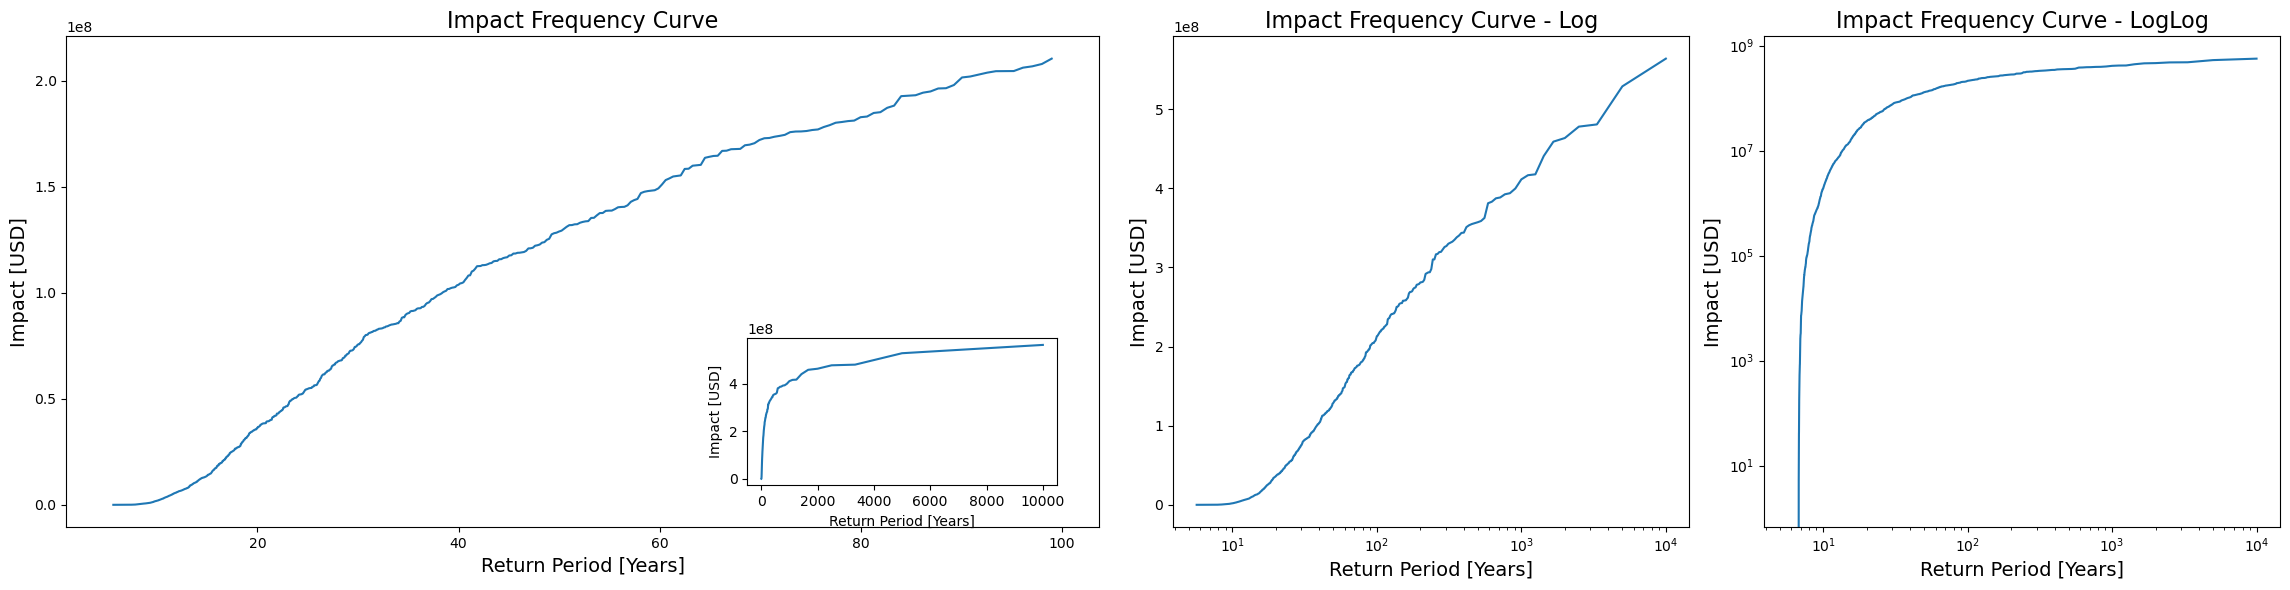

In [110]:
imp, imp_per_event, imp_admin_evt = cimp.init_imp(exp, tc_storms, admin_gdf) 
imp_per_event_flt, imp_admin_evt_flt, to_protect = bpd.init_imp_flt(imp_per_event, imp_admin_evt, lower_rp)

Using the identified TC hazards we calculate the impact of each hazard event on the country. Furhtermore, we calculate the impact of each hazard event on each subarea. 
Next, we determine what damage value corresponds to our predefined return period which we want to protect. All damages which are smaller than the determined value are set to zero. This is done to avoid payouts for events with a lower return period and is therefore used in the calibration of the payout function.

#### Extract Hazard Intensity per Event and Subarea


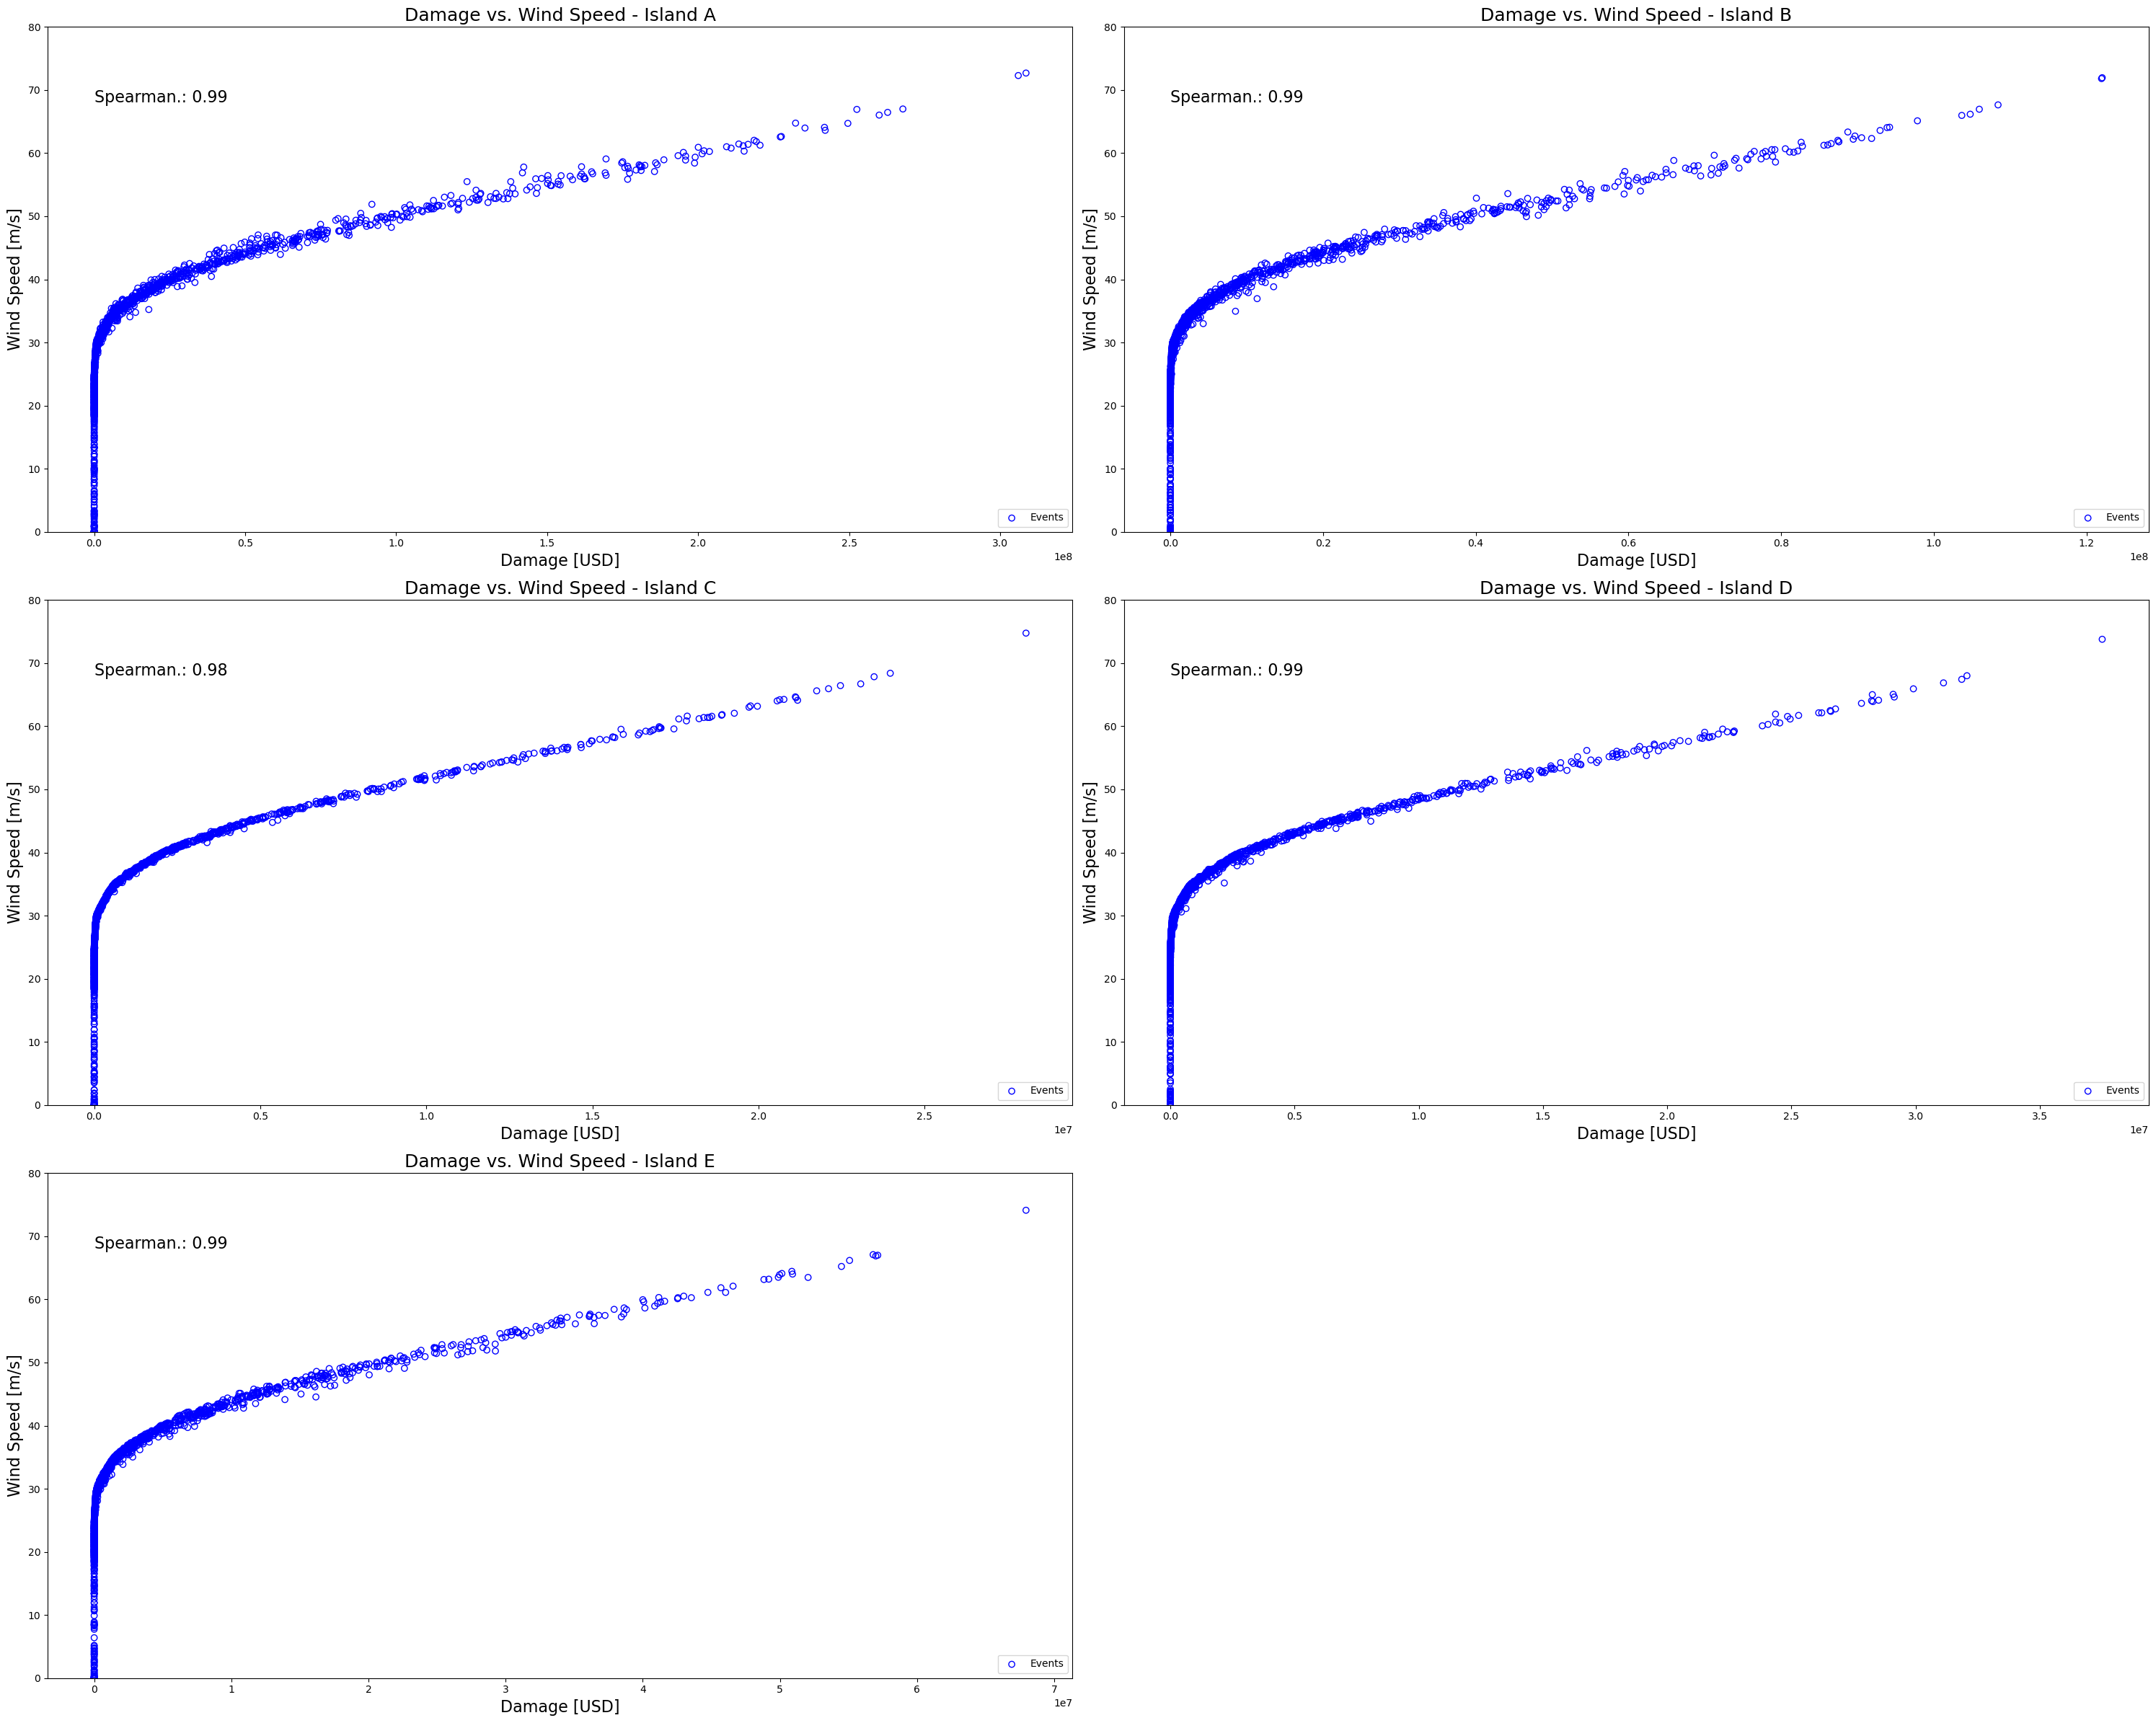

In [111]:
int_grid = hig.init_haz_int(grid_gdf, admin_gdf, tc_storms=tc_storms, stat='mean') 
hig.plt_int_dam(imp_admin_evt,int_grid)

Here we extract the wind speed per event and subarea. This is done using either the mean of the wind speed or a specified percentile of the wind speed across the subarea. For this example we will continue with the mean, but it can be changed if you want to play around with it. 
We will also add the year of the hazard event in a column. This will be needed when we simulate the bond.
Looking at the plotted figure we can see that the damage per subarea is closely linked to the mean wind speed. The spearman rank correlation is 0.98 respectively 0.99 and therefore satisfactory for our needs. 

### Define Insurance Policies

#### Calculate Needed Capital


In [151]:
#define nominal
nominal = snom.init_nominal(impact=imp, exposure=exp, prot_rp=250)

The principal of the cat bond is: 310183718.521 [USD]
Principal as share of GDP: 0.357


As we have calculated the impact per event we can now determine what capital is needed to protect our preset maximum return period. This will be used as the total capital of the bond and therefore, represents the maximum available money to cover a damage during the term of the bond. 
For Grenada the chosen maximum return period of 50 year corresponds roughly to 100 Million USD which is 10% of the countrys GDP. Compared to other cat bonds issued by the world bank the absolute amount is realistic. However, 10% of a countrys GDP is unuasaly large which reflects the vulnerability of Grenada to tropical cyclones.

The function also allows to set the total capital for the bond using percentage of GDP. Using this method one can better foresee what the bond means in terms of a financial burden to the country.

#### Optimization of Payout Function


In [113]:
result, optimized_step1, optimized_step2 = apo.init_alt_optimization(int_grid, nominal, damages_grid=imp_admin_evt_flt)

{0: (45.82439230194751, 72.5295525442872), 1: (45.922799242604825, 73.41494368479708), 2: (49.755517789602166, 71.29269057094692), 3: (47.89389771781436, 73.05081651994377), 4: (47.071955812971446, 70.34956987197985)}


Using the mean wind speed per event and subarea, as well as the damage per subarea (filtered for the damages equal or above our chosen minimum return period), the wind speed thresholds for a payout are optimized. The optimization uses the criterion of the basis risk (difference between damage and payout). 
The final thresholds can be seen above for each of the two subareas. The first value per subarea indicates the minimum threshold, so the minimum mean wind speed which will trigger a payout. The second value per subarea is the maximum threshold, so the mimimal mean wind speed which triggers the payout of the full bond. After a total payout occurs there is no money left in the bond so it is terminated.

#### Assess Payout vs Damage for Each Event

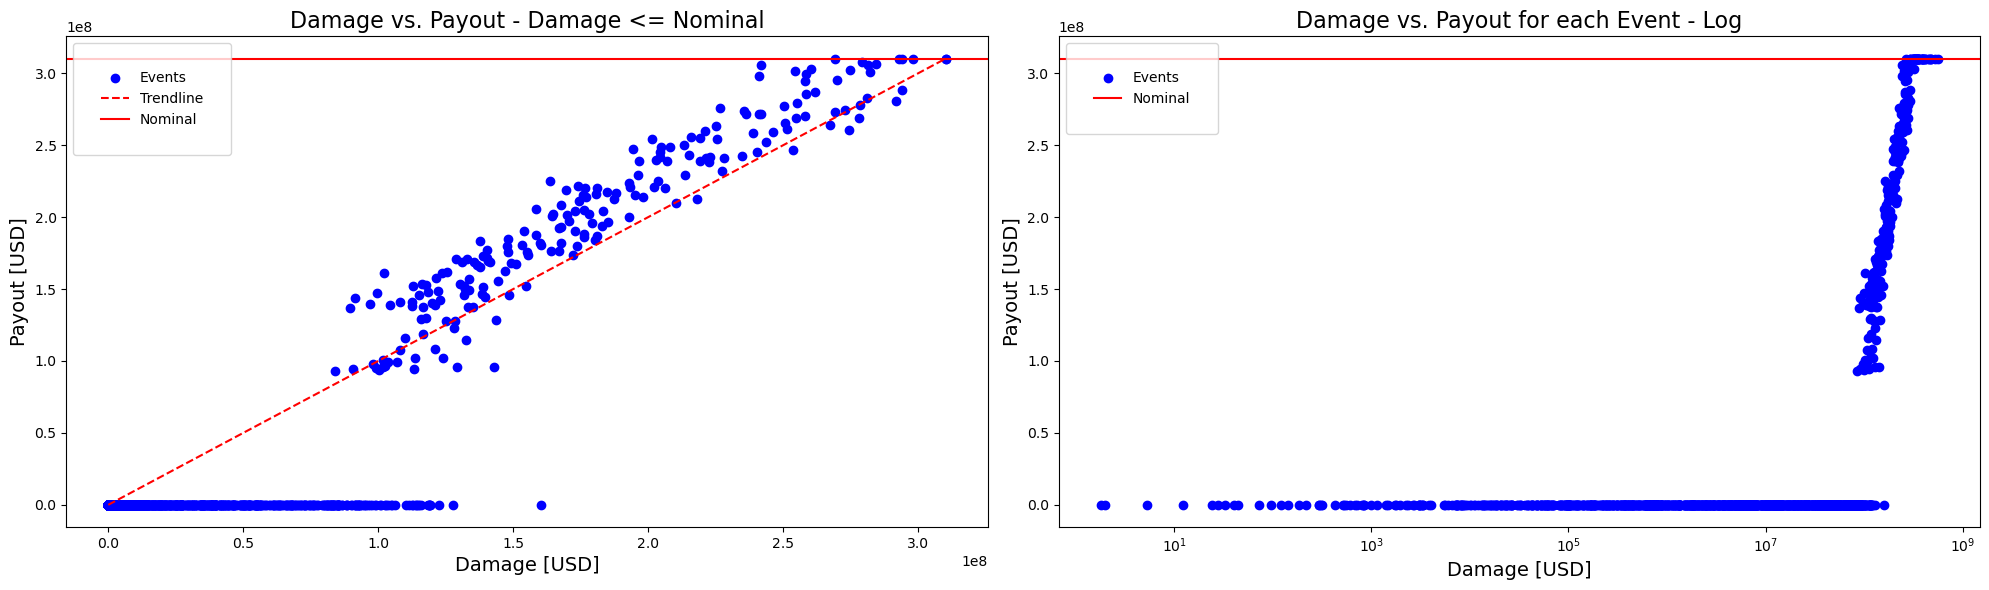

Spearman's correlation coefficient: 0.814


In [114]:
pay_dam_df = apo.alt_pay_vs_damage(imp_per_event_flt, 
                                   optimized_step1, 
                                   optimized_step2, 
                                   int_grid, nominal, 
                                   imp_admin_evt, 
                                   imp_per_event)
corr, pval = spearmanr(pay_dam_df['pay'], pay_dam_df['damage'])
print("Spearman's correlation coefficient:", round(corr,3))

In the left plot we can see the payout vs damage in a 1:1 plot for damages euqal or smaller than the specified maximum return period (50 years in this case). Each blue point represents one event on our dataset. The closer the points to the red dashed line the smaller is the remaining basis risk. The maximum payout per event is limited by the total capital of our bond and is represented in the plot by the horizontal red line.
The minimum payout of the bond is 30% which is why the points do not follow the red dashed euqality line until zero.
We can also see that the payouts mostly start above 30 Million USD which correspons roughly to our chosen minimum return period.

In the right plot we can see payout vs. damage for all events in the dataset using a log scale for the x-axis. 

Spearmans correaltion coefficient is reported as 0.97 which confirms that there is a close relationship between payout and damage. Therefore, we can conclude that the optimization of the payout worked appropriately.

#### Calculate Bond Metrics

In [115]:
exp_loss_ann, att_prob, ann_losses, es_metrics = sb.init_exp_loss_att_prob_simulation(pay_dam_df, nominal)

Expected Loss = 0.016569368877467346
Attachment Probability = 0.023538040941521635


Now that we have a payout function in place we can simulate the bond. Using our dataset we will simulate a bond with a 3 year term. The first bond is created for the years 1, 2, 3, the second bond for the years 2, 3, 4, and so on until we have used all 10000 years of data. 
Using the outcomes of the simulation the annual expected loss, annual attachment probability (probability that a payout is triggered in one year), Value at Risk, and expected shortfall are calculated. Furthermore, a list with all the annual losses during the simulation is created, as this will be needed later to determine the appropritate price of the bond.

As we can see the annual expected loss of the bond is 3.2% and the annual attachment probability is 4.0%. This is expected as our chosen minimum return period of 25 years corresponds to an  annual attachment probability of 4%. These values are in a reasonable range for cat bonds issued by the World Bank.

#### Calculate Premiums:
1. IBRD multiplier 
2. Linear regression model from Chatoro et al. 2022
3. Target Sharpe Ratio

In [116]:
#define necesarry parameters
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd

#calculate premiums
premium_ibrd = prib.monoExp(exp_loss_ann*100, a, k, b) * exp_loss_ann
premium_regression = cp.calc_premium_regression(exp_loss_ann *100)/100
premium_sharpe = sb.init_prem_sharpe_ratio(ann_losses, rf_rate, target_sharpe)

print(f'The premium based on past IBRD bonds is {round(premium_ibrd*100, 1)}% which corresponds to {round(premium_ibrd*nominal,0)} USD')
print(f'The premium based on the regression model from Chatoro et al. 2022 is {round(premium_regression*100, 1)}% which corresponds to {round(premium_regression*nominal,0)} USD')
print(f'The premium based on required sharpe ration of {target_sharpe} is {round(premium_sharpe*100, 1)}% which corresponds to {round(premium_sharpe*nominal,0)} USD')

The premium based on past IBRD bonds is 4.8% which corresponds to 15015225.0 USD
The premium based on the regression model from Chatoro et al. 2022 is 6.6% which corresponds to 20492073.0 USD
The premium based on required sharpe ration of 0.5 is 8.0% which corresponds to 24816121.0 USD


The price suggested by the IBRD multiplier is by far the cheapest, approximately 2% to 8% cheaper than the pricing methods using a linear regression or a benchmark financial metric. This corresponds to differences between 2 to 8 million USD, so not negligible for such small countries like St. Kitts and Nevis.

Overall the prices for the cat bond range between approximately 7 to 15 million USD per year. 

#### Simulate Final Bond

In [117]:
bond_metrics, returns = sb.init_bond_simulation(pay_dam_df, premium_ibrd, rf_rate, nominal) 
print('Sharpe Ratio: ',round(bond_metrics['Sharpe_ratio_ann'][0],2))
print('Coverage: ',round(bond_metrics['Coverage'][0]*100,1),'%')


Sharpe Ratio:  0.26
Coverage:  79.9 %


Using the price calculated by the IBRD multiplier the bond offers a sharpe ratio of 0.14 to investors. 
Independent of the pricing technique a coverage of 56.2% is achieved. Which means 56.2% of all damages with a return period of 25 or greater occured during the simulation of the bond are covered by payouts from the bond.

But is this the maximum coverage we can achieve for Grenada? Let's see how much space for improvement there is and how this will impact the price Grenada has to pay.

### Cat Bond Simulation using Different Capital

In order to evaluate how the coverage and the demanded price evolves when using a different capital we will simulate the bond using the same setting as specified above but changing the total capital available in the bond. To ensure that the capital available in the bond is used in an optimal way to protect our assets we will optimize the payout thresholds seperately for each bond.

The simulated capital values start from 50 million USD up to 450000 million USD with an increment of 100 million USD.

Progress |██████████████████████████████████████████████████| 100.0% Complete


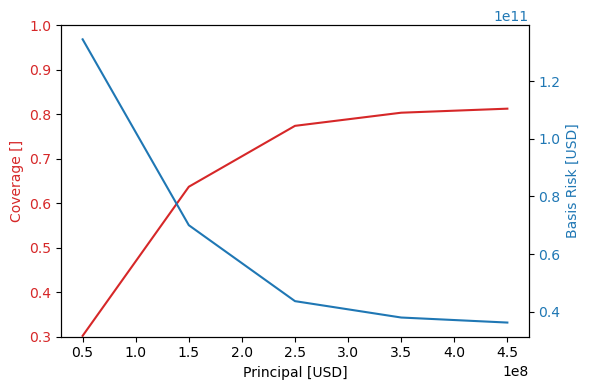

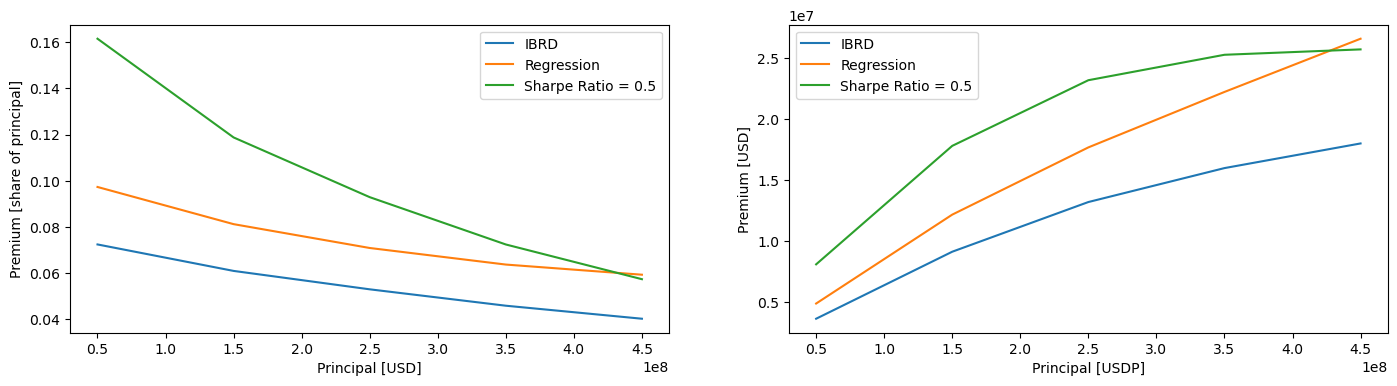

In [118]:
#define different capitals of the bond
arr_nominal = np.arange(50000000, 500000001, 100000000)


bond_metrics_nom, returns_nom, premium_dic_nom, es_metrics_nom, pay_dam_df_nom, optimized_xs_nom, optimized_ys_nom = cdf.sng_bond_nom(arr_nominal=arr_nominal,
                                                                                                                                      int_grid=int_grid,
                                                                                                                                      imp_admin_evt_flt=imp_admin_evt_flt,
                                                                                                                                      imp_per_event_flt=imp_per_event_flt,
                                                                                                                                      rf_rate=rf_rate,
                                                                                                                                      target_sharpe=target_sharpe)
    

First we will evaluate the provided coverage by the different bonds. Not surprsingly, the higher the capital in the bond, the higher the coverage until it reaches close to 100%. Accordingly, the basis risk decreases with increasing capital until it gets close to zero. From the plot we can conclude that a capital of 250 million USD is needed to insure 90% of the damages in Grenada, looking at events with a return period of 25 years or higher. This corresponds approximately to 20% of the countries GDP. 

The price for such a bond will therefore need a significant part of the countries GDP. For a coverage of over 90% between 12 to 25 million USD have to be paid annualy to investors according to our pricing methods. This is equal to 1% up to 2% of Grenadas GDP. The lowest price is given for the IBRD multiplier followed by the formula proposed by Chatoro et al., 2023 and last the target sharpe ratio. 

However, the realtive premiums are decreasing with increasing capital. This is because the expected loss and the standard deviation of losses are decreasing with increasng capital. The relative price needed to meet the target sharpe ratio is decreasing more strongly than the premiums calculated by other methods and is approximately the same for the bond using the highest simulated capital. 

Despite that the relative price is decreasing, the absolute prices are higher the greater the capital in the bond. Though the increase in price slows down the higher the capital. 

But what happens when we create a bond for multiple countries? Can we achieve the same coverage for a cheaper price? Can we make insurance more affordable to countries who need it?

## Create Multiple Single-Country Bonds

To create a multi-country bond we first have to create more single-country bonds. We will do this for the carribean state St. Kitts and Nevis using the same setting as for Grenada, so the bond should insure damages with a return period of 25 years or higher and has a capital equal to a damage with a return period of 50 years.

Additionally, we will create a bond for the island state Comoros, located in the Southern Indian basin close to Madagascar. As Comoros is not as heavily affected by tropical cyclones as our chosen Caribean countries we will use higher return periods. The bond we will create is designed to insure damages with a return period of 100 years or larger and comes with a capital suitable to protect from a damage with a return period of 250 years. Consequently, this bond should have a much lower attachment probability as well as expected loss compared to the other bonds.

In [119]:
print(Back.RED + "St. Kitts and Nevis")
bond_metrics_kitt, returns_kitt, premium_dic_kitt, nominal_kitt, pay_dam_df_kitt, es_metrics_kitt, int_grid_kitt, imp_per_event_flt_kitt, imp_admin_evt_flt_kitt = bond_fct.sng_cty_bond(country=659, 
                                                                                                                                                                                         prot_share=upper_rp, 
                                                                                                                                                                                         rf_rate=rf_rate, 
                                                                                                                                                                                         target_sharpe=target_sharpe, 
                                                                                                                                                                                         low_to_prot=lower_rp)

print(Back.RED + "Comoros")
bond_metrics_com, returns_com, premium_dic_com, nominal_com, pay_dam_df_com, es_metrics_com, int_grid_com, imp_per_event_flt_com, imp_admin_evt_flt_com = bond_fct.sng_cty_bond(country=174, 
                                                                                                                                                                                prot_share=250, 
                                                                                                                                                                                rf_rate=rf_rate, 
                                                                                                                                                                                target_sharpe=target_sharpe, 
                                                                                                                                                                                low_to_prot=100)

St. Kitts and Nevis
Number of tracks in NA basin: 946
The principal of the cat bond is: 80453906.699 [USD]
Principal as share of GDP: 0.091
Comoros
Number of tracks in SI basin: 229
The principal of the cat bond is: 116444517.304 [USD]
Principal as share of GDP: 0.095


Now that we have created the bonds we can assess the basics of them. First we see that the subareas for the payout are equal to the islands of the countries except for the largest island of Comoros which is big enough to be divided into two subareas. According to to our algorithm an area should only be divided into subareas when the size of each area can be equal or bigger than 600 km^2. 

Next, much more tropical cyclone events can potentially trigger a payout in St. Kitts and Nevis compared to Comoros. This reflects the overall lower tropical cyclone danger in Comoros compared to Grenada and St. Kitts and Nevis. 

The damages caused by tropical cyclones in the two countries differ a lot. However, due to the differing chosen return periods they each protect, the total needed capital available in the bonds is roughly the same (105 vs 116 million USD). As the GDPs of both countries are similar this corresponds to roughly 10% of each countries GDP.

In [120]:
#print relevant metrics for both single country bonds
print(Back.RED + "St. Kitts and Nevis")
print(Style.RESET_ALL)
fct.print_sng_bnd_rel_metr(bond_metrics=bond_metrics_kitt, 
                           returns=returns_kitt, 
                           premium_dic=premium_dic_kitt, 
                           nominal=nominal_kitt)
print(Style.RESET_ALL)
print(Back.RED + "Comoros")
print(Style.RESET_ALL)
fct.print_sng_bnd_rel_metr(bond_metrics=bond_metrics_com, 
                           returns=returns_com, 
                           premium_dic=premium_dic_com, 
                           nominal=nominal_com)

St. Kitts and Nevis

Expected Loss: 2.9 %
Attachment Probability: 3.4 %
Coverage: 52.5 %
Premium Ibrd: 6.2 %; 4987690.0 USD
Premium Chatoro et al. 8.3 %; 6661510.0 USD
Premium Target Sharpe Ratio 12.5 %; 10061913.0 USD
Standard Deviation of Returns 0.17

Comoros

Expected Loss: 0.6 %
Attachment Probability: 0.7 %
Coverage: 43.2 %
Premium Ibrd: 2.5 %; 2854897.0 USD
Premium Chatoro et al. 5.1 %; 5912339.0 USD
Premium Target Sharpe Ratio 4.3 %; 5021166.0 USD
Standard Deviation of Returns 0.08


As anticipated we see that the expected loss for St. Kitts and Nevis is much higher compared to Comoros. This difference is also seen in the price which has to be paid, which is much lower for Comoros. Interestingly, while we see the same pricing pattern for St. Kitts and Nevis compared to Grenada (IBRD is cheapest and meeting the target sharpe ratio the most expensive), Comoros shows a bit of a different pattern. While the IBRD price still is the lowest, the price for the target sharpe ratio comes second. This is because the standard deviation of returns is much lower for Comoros (0.08) compared to St. Kitts and Nevis (0.18), thus the expected returns are allowed to be much lower for Comoros in order to meet the same sharpe ratio. 

The coverage provided to the countries is 52.5% for St. Kitts and Nevis and 43.2% for Comoros.

## Create Multi-Country Bonds

Now we can finally create multi-country bonds. We have 3 different countries which we can freely pool. Lets explore our options and the consequences for the prices. 
The pooling takes place under the constraint that the coverage for the countries has to be exactly the same compared to their individual single-country bond. 

First, we need to create lists of countries we want to pool and then create dictionaries for the capital used in the bond for each country in the pool (nominal) and also for the dataframes containing the year, payout and damage per event (pay_dam_df). In the code chunk below this is done for all possible pooling combinations.

In the notebook only one example for pooling is showed. However feel free to use the provided functions and dictionaries to create your own country pool. You can also change the settings for the single-country bonds (e.g. what events they should insure) and have a look how this affects the prices, the coverage, and the pooling combinations.

In [121]:
country_1 = 882 #Grenada
country_2 = 659 #St. Kitts and Nevis
country_3 = 174 #Comoros

#Pool 1: Grenada and St. Kitts and Nevis
countries_1 = [country_1, country_2]
nominal_dic_1 = {country_1: nominal,
                 country_2: nominal_kitt}
pay_dam_df_dic_1 = {country_1: pay_dam_df,
                    country_2: pay_dam_df_kitt}

#Pool 2: Grenada and Comoros
countries_2 = [country_1, country_3]
nominal_dic_2 = {country_1: nominal,
                 country_3: nominal_com}
pay_dam_df_dic_2 = {country_1: pay_dam_df,
                    country_3: pay_dam_df_com}

#Pool 3: St. Kitts and Nevis and Comoros
countries_3 = [country_2, country_3]
nominal_dic_3 = {country_2: nominal_kitt,
                 country_3: nominal_com}
pay_dam_df_dic_3 = {country_2: pay_dam_df_kitt,
                    country_3: pay_dam_df_com}

#Pool 4: Grendada, St. Kitts and Nevis, and Comoros
countries_4 = [country_1, country_2, country_3]
nominal_dic_4 = {country_1: nominal,
                 country_2: nominal_kitt,
                 country_3: nominal_com}
pay_dam_df_dic_4 = {country_1: pay_dam_df,
                    country_2: pay_dam_df_kitt,
                    country_3: pay_dam_df_com}

The following will create a multi-county bond insuring Grenada and St. Kitts and Nevis providing boht countries exactly the same coverage compared to their indiviudal single country bonds.

In [122]:
bond_metrics_pool_1, returns_pool_1, tot_coverage_cty_pool_1, premium_dic_pool_1, nominal_pool_1, es_metrics_pool_1, MES_cty_pool_1 = bond_fct.mlt_cty_bond(countries=countries_1,
                                                                                                                                                            pay_dam_df_dic_ps=pay_dam_df_dic_1,
                                                                                                                                                            nominals_dic_ps=nominal_dic_1,
                                                                                                                                                            rf_rate=rf_rate,
                                                                                                                                                            target_sharpe=target_sharpe)



In [123]:
print(Back.RED + 'Pool 1: Grenada + St. Kitts and Nevis')
print(Style.RESET_ALL)
fct.print_mlt_bnd_rel_metr(countries=countries_1, returns=returns_pool_1,
                           premium_dic=premium_dic_pool_1,
                           tot_coverage_cty=tot_coverage_cty_pool_1,
                           nominal=nominal_pool_1)

Pool 1: Grenada + St. Kitts and Nevis

Expected Loss:  1.9 %
Attachment Probability:  5.7 %
Coverage 882: 79.9 %
Coverage 659: 52.5 %
Premium Ibrd:  5.2 %;  20199891.0 USD
Premium Chatoro et al. 7.0 %;  27153583.0 USD
Premium Target Sharpe Ratio 7.3 %;  28373645.0 USD
Standard Deviation Returns 0.10162811577889687


In [124]:
ibrd_sng_pool_1 = premium_ibrd*nominal + premium_dic_kitt['ibrd']*nominal_kitt
regr_sng_pool_1 = premium_regression*nominal + premium_dic_kitt['regression']*nominal_kitt
requ_sng_pool_1 = premium_sharpe*nominal + premium_dic_kitt['required']*nominal_kitt

print(Back.RED + 'Pool 1: Grenada + St. Kitts and Nevis')
print(Style.RESET_ALL)
print('Chatoro et al.: ',  round((1 - (premium_dic_pool_1['regression'] * nominal_pool_1) / regr_sng_pool_1)*100,1),'% - no change in price')
print('IBRD: ',  round((1 - (premium_dic_pool_1['ibrd'] * nominal_pool_1) / ibrd_sng_pool_1)*100,1),'% - no change in price')
print('Target Sharpe Ratio: ',  round((1 - (premium_dic_pool_1['required'] * nominal_pool_1) / requ_sng_pool_1)*100,1),'% cheaper')

Pool 1: Grenada + St. Kitts and Nevis

Chatoro et al.:  0.0 % - no change in price
IBRD:  -1.0 % - no change in price
Target Sharpe Ratio:  18.6 % cheaper


As expected there is no change in the price when using the regression model. As expected loss is an additive property and the price is modeled as a linear function of the expected loss it does not matter if we pool the countries or not. Futhermore, there is also no change in price when using the IBRD method. This is not as trivial as for the regression model, but based on the 3D-plot shown during the presentation pooling countries with high losses should not result in any change regarding the price. 

However, the price to meet a specified sharpe ratio changed significantly. Now we can achieve a sharpe ratio of 0.5 by paying 22.5% less premiums annualy. Therefore, the same coverage can be achieved with less money but still being attractive to potenital investors. 

Feel free to explore more pooling options, or chaning the bonds set-ups. There is much more to expolore!

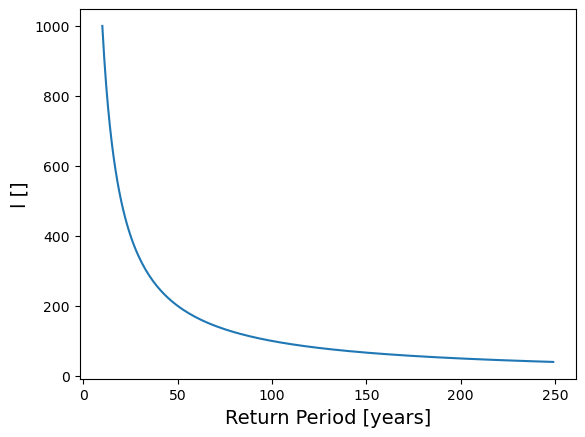

In [143]:
import matplotlib.pyplot as plt
x = np.arange(10,250,1)
y = 1/x*10000

plt.plot(x,y)
plt.xlabel('Return Period [years]', fontsize=14)
plt.ylabel('l []', fontsize=14)
plt.show()

[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12
 0.125 0.13  0.135 0.14  0.145 0.15 ]


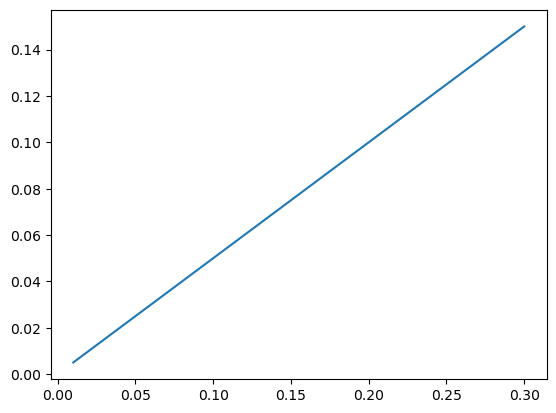

In [126]:
x = np.arange(0.01,0.31,0.01)
y = x/2
print(y)
plt.plot(x,y)

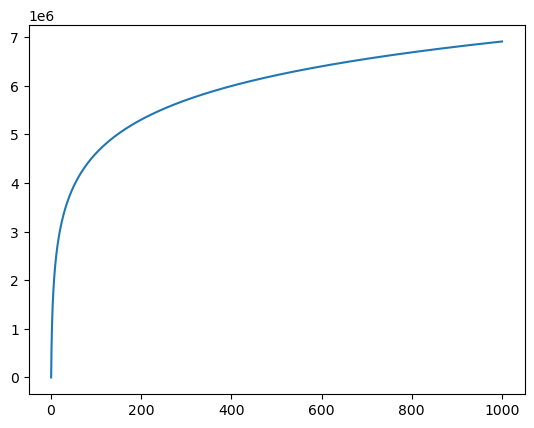

In [133]:
x = np.arange(1,1000,0.001)
y = np.log(x)*1000000

plt.plot(x,y)

In [128]:
import n_fct_t_rl_thm_ll as bond_fct
to_prot_arr = np.arange(40,260,10)

ps = {}
pd = {}
es = {}
r = {}

for i in range(len(to_prot_arr)):
    premium_simulation_ps, returns_ps, premium_dic, nom_arr, pay_dam_df_ps, es_metrics_ps, int_grid, imp_per_event_flt, imp_admin_evt_flt = bond_fct.sng_cty_bond(882,
                                                                                                                                                                  250,
                                                                                                                                                                  rf_rate,
                                                                                                                                                                  target_sharpe,
                                                                                                                                                                  low_to_prot=to_prot_arr[i])
    ps[i] = premium_simulation_ps
    pd[i] = premium_dic
    es[i] = es_metrics_ps
    r[i] = returns_ps
    

Number of tracks in SP basin: 1767
The principal of the cat bond is: 310183718.521 [USD]
Principal as share of GDP: 0.357
Number of tracks in SP basin: 1767
The principal of the cat bond is: 310183718.521 [USD]
Principal as share of GDP: 0.357
Number of tracks in SP basin: 1767
The principal of the cat bond is: 310183718.521 [USD]
Principal as share of GDP: 0.357
Number of tracks in SP basin: 1767
The principal of the cat bond is: 310183718.521 [USD]
Principal as share of GDP: 0.357
Number of tracks in SP basin: 1767
The principal of the cat bond is: 310183718.521 [USD]
Principal as share of GDP: 0.357
Number of tracks in SP basin: 1767
The principal of the cat bond is: 310183718.521 [USD]
Principal as share of GDP: 0.357
Number of tracks in SP basin: 1767
The principal of the cat bond is: 310183718.521 [USD]
Principal as share of GDP: 0.357
Number of tracks in SP basin: 1767
The principal of the cat bond is: 310183718.521 [USD]
Principal as share of GDP: 0.357
Number of tracks in SP b

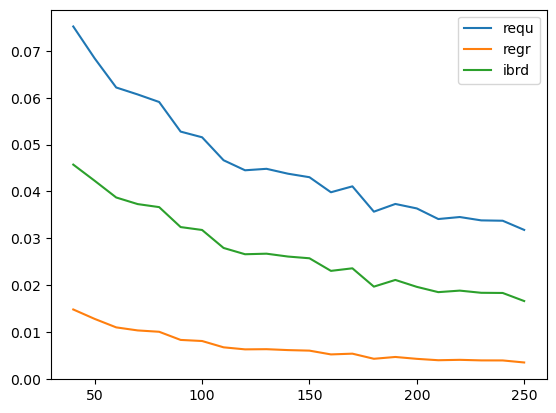

In [141]:
requ = []
returns = []
ibrd = []
regr = []
std = []
el = []
for i in range(len(to_prot_arr)):
    requ.append(pd[i]['required'])
    ibrd.append(pd[i]['ibrd'])
    regr.append(pd[i]['regression'])
    el.append(pd[i]['exp_loss'])

    returns.append(np.mean(r[i]['Annual'][0]))
    std.append(np.std(r[i]['Annual'][0]))

requ=np.array(requ)
plt.plot((to_prot_arr),requ, label='requ')
plt.plot((to_prot_arr),el, label='regr')
plt.plot((to_prot_arr),ibrd, label='ibrd')
plt.legend()


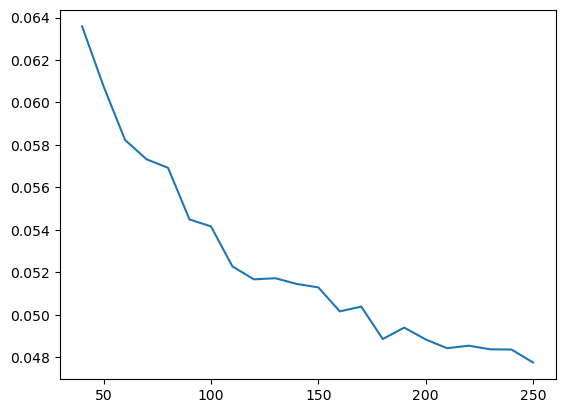

In [130]:
plt.plot((to_prot_arr),requ)
